In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
import scipy.stats as stats
from sklearn.model_selection import KFold

In [3]:
main_df = pd.read_csv('main_and_nfl.csv')

In [4]:
main_df.head()

,link,nfl_stats,year_drafted,name,position,age,av,school,stats,height,...,40yd,vert,bench_reps,broad_jump,3cone,shuttle,Drafted(tm/rnd/yr),rookie_scrim_yds,pick_number,round_number
Trayveon Williams,https://www.sports-reference.com/cfb/players/t...,/players/W/WillTr06.htm,2019,Trayveon Williams,RB,21,0,Texas A&M,College Stats,68.0,...,4.51,33.0,19.0,121.0,7.44,4.44,Cincinnati Bengals / 6th / 182nd pick / 2019,NaN,182,6
Dexter Williams,https://www.sports-reference.com/cfb/players/d...,/players/W/WillDe07.htm,2019,Dexter Williams,RB,22,0,Notre Dame,College Stats,71.0,...,4.57,36.0,17.0,130.0,7.00,4.16,Green Bay Packers / 6th / 194th pick / 2019,11.0,194,6
Devin Singletary,https://www.sports-reference.com/cfb/players/d...,/players/S/SingDe00.htm,2019,Devin Singletary,RB,21,6,Florida Atlantic,College Stats,67.0,...,4.66,35.0,15.0,117.0,7.32,4.40,Buffalo Bills / 3rd / 74th pick / 2019,969.0,74,3
Jordan Scarlett,https://www.sports-reference.com/cfb/players/j...,/players/S/ScarJo00.htm,2019,Jordan Scarlett,RB,23,0,Florida,College Stats,71.0,...,4.47,30.0,21.0,116.0,7.37,4.63,Carolina Panthers / 5th / 154th pick / 2019,9.0,154,5
Miles Sanders,https://www.sports-reference.com/cfb/players/m...,/players/S/SandMi01.htm,2019,Miles Sanders,RB,21,9,Penn State,College Stats,71.0,...,4.49,36.0,20.0,124.0,6.89,4.19,Philadelphia Eagles / 2nd / 53rd pick / 2019,1327.0,53,2


In [5]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, Trayveon Williams to Shaun Alexander
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   link                390 non-null    object 
 1   nfl_stats           390 non-null    object 
 2   year_drafted        390 non-null    int64  
 3   name                390 non-null    object 
 4   position            390 non-null    object 
 5   age                 390 non-null    int64  
 6   av                  390 non-null    int64  
 7   school              390 non-null    object 
 8   stats               390 non-null    object 
 9   height              390 non-null    float64
 10  weight              390 non-null    int64  
 11  40yd                381 non-null    float64
 12  vert                320 non-null    float64
 13  bench_reps          301 non-null    float64
 14  broad_jump          316 non-null    float64
 15  3cone               223 non-null  

Since 'rookie_scrim_yds' is my target, I need to make sure all rows have a target.

In [6]:
main_df.shape

(390, 21)

In [7]:
# remove all rows that do not have my target (rookie_scrim_yds):
main_df = main_df[~main_df['rookie_scrim_yds'].isin([None])]
main_df.shape

(334, 21)

In [8]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, Dexter Williams to Shaun Alexander
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   link                334 non-null    object 
 1   nfl_stats           334 non-null    object 
 2   year_drafted        334 non-null    int64  
 3   name                334 non-null    object 
 4   position            334 non-null    object 
 5   age                 334 non-null    int64  
 6   av                  334 non-null    int64  
 7   school              334 non-null    object 
 8   stats               334 non-null    object 
 9   height              334 non-null    float64
 10  weight              334 non-null    int64  
 11  40yd                327 non-null    float64
 12  vert                273 non-null    float64
 13  bench_reps          254 non-null    float64
 14  broad_jump          269 non-null    float64
 15  3cone               192 non-null    

In [9]:
main_df.describe()

,year_drafted,age,av,height,weight,40yd,vert,bench_reps,broad_jump,3cone,shuttle,rookie_scrim_yds,pick_number,round_number
count,334.000000,334.000000,334.000000,334.000000,334.000000,327.000000,273.000000,254.000000,269.000000,192.000000,199.000000,334.000000,334.000000,334.000000
mean,2009.946108,21.730539,18.299401,70.658683,216.068862,4.536728,34.697802,19.822835,118.609665,7.043906,4.255729,459.664671,84.895210,2.892216
std,5.496117,0.998119,23.936607,1.684668,12.531691,0.103905,3.084484,4.308750,5.716569,0.203235,0.148624,469.997069,73.768637,2.200273
min,2000.000000,20.000000,0.000000,66.000000,180.000000,4.240000,26.500000,9.000000,104.000000,6.500000,3.930000,-1.000000,0.000000,0.000000
25%,2005.250000,21.000000,3.000000,70.000000,208.000000,4.460000,32.500000,17.000000,115.000000,6.897500,4.150000,69.000000,13.500000,1.000000
50%,2010.500000,22.000000,8.000000,71.000000,216.000000,4.540000,34.500000,20.000000,118.000000,7.040000,4.230000,303.000000,72.000000,3.000000
75%,2014.000000,22.000000,26.000000,72.000000,225.000000,4.605000,36.500000,22.000000,122.000000,7.170000,4.360000,733.000000,138.750000,4.750000
max,2019.000000,25.000000,157.000000,75.000000,259.000000,4.830000,43.000000,31.000000,137.000000,7.680000,4.670000,2028.000000,257.000000,7.000000


Above, the minimum rookie_scrim_yds is -1. Since there is no way to know exactly what is meant by this, I will drop this row.

In [10]:
main_df[main_df['rookie_scrim_yds']==-1]

,link,nfl_stats,year_drafted,name,position,age,av,school,stats,height,...,40yd,vert,bench_reps,broad_jump,3cone,shuttle,Drafted(tm/rnd/yr),rookie_scrim_yds,pick_number,round_number
Andre Brown,https://www.sports-reference.com/cfb/players/a...,/players/B/BrowAn03.htm,2009,Andre Brown,RB,22,7,North Carolina State,College Stats,72.0,...,4.37,37.0,24.0,115.0,7.35,4.33,New York Giants / 4th / 129th pick / 2009,-1.0,129,4


In [11]:
main_df = main_df.drop(['Andre Brown'])
main_df.describe()

,year_drafted,age,av,height,weight,40yd,vert,bench_reps,broad_jump,3cone,shuttle,rookie_scrim_yds,pick_number,round_number
count,333.000000,333.000000,333.000000,333.000000,333.000000,326.000000,272.000000,253.000000,268.000000,191.000000,198.000000,333.000000,333.000000,333.000000
mean,2009.948949,21.729730,18.333333,70.654655,216.045045,4.537239,34.689338,19.806324,118.623134,7.042304,4.255354,461.048048,84.762763,2.888889
std,5.504142,0.999511,23.964582,1.685592,12.542977,0.103652,3.086992,4.309232,5.722986,0.202549,0.148907,470.022857,73.839868,2.202743
min,2000.000000,20.000000,0.000000,66.000000,180.000000,4.240000,26.500000,9.000000,104.000000,6.500000,3.930000,0.000000,0.000000,0.000000
25%,2005.000000,21.000000,3.000000,70.000000,208.000000,4.460000,32.500000,17.000000,115.000000,6.895000,4.150000,69.000000,13.000000,1.000000
50%,2011.000000,22.000000,8.000000,71.000000,216.000000,4.540000,34.500000,20.000000,118.500000,7.040000,4.225000,304.000000,71.000000,3.000000
75%,2014.000000,22.000000,26.000000,72.000000,225.000000,4.607500,36.500000,22.000000,122.000000,7.165000,4.360000,735.000000,139.000000,5.000000
max,2019.000000,25.000000,157.000000,75.000000,259.000000,4.830000,43.000000,31.000000,137.000000,7.680000,4.670000,2028.000000,257.000000,7.000000


Need to change all rows where pick_number==0 (ie. undrafted) to an appropriate pick number above the highest possible pick number (256). 

Similarly, change all rows where round_number==0 (ie. undrafted) to an appropriate round number above the highest possible round number (7).

In [12]:
#highest draft pick number possible = 256
#change players who werent picked in NFL draft to pick_number = 275 (above the highest number in draft)
main_df['pick_number'] = main_df['pick_number'].replace(0,275)
#highest draft round number possible = 7
#change players who were undrafted to round=8:
main_df['round_number'] = main_df['round_number'].replace(0,8)

In [13]:
main_df.describe()

,year_drafted,age,av,height,weight,40yd,vert,bench_reps,broad_jump,3cone,shuttle,rookie_scrim_yds,pick_number,round_number
count,333.000000,333.000000,333.000000,333.000000,333.000000,326.000000,272.000000,253.000000,268.000000,191.000000,198.000000,333.000000,333.000000,333.000000
mean,2009.948949,21.729730,18.333333,70.654655,216.045045,4.537239,34.689338,19.806324,118.623134,7.042304,4.255354,461.048048,136.789790,4.402402
std,5.504142,0.999511,23.964582,1.685592,12.542977,0.103652,3.086992,4.309232,5.722986,0.202549,0.148907,470.022857,90.782231,2.434737
min,2000.000000,20.000000,0.000000,66.000000,180.000000,4.240000,26.500000,9.000000,104.000000,6.500000,3.930000,0.000000,2.000000,1.000000
25%,2005.000000,21.000000,3.000000,70.000000,208.000000,4.460000,32.500000,17.000000,115.000000,6.895000,4.150000,69.000000,58.000000,2.000000
50%,2011.000000,22.000000,8.000000,71.000000,216.000000,4.540000,34.500000,20.000000,118.500000,7.040000,4.225000,304.000000,119.000000,4.000000
75%,2014.000000,22.000000,26.000000,72.000000,225.000000,4.607500,36.500000,22.000000,122.000000,7.165000,4.360000,735.000000,221.000000,7.000000
max,2019.000000,25.000000,157.000000,75.000000,259.000000,4.830000,43.000000,31.000000,137.000000,7.680000,4.670000,2028.000000,275.000000,8.000000


**Fill all null values for combine stats with the mean for each combine event:**

In [14]:
main_df['40yd'] = main_df['40yd'].fillna(main_df.mean()['40yd']).round(2)
main_df['vert'] = main_df['vert'].fillna(main_df.mean()['vert']).round(1)
main_df['bench_reps'] = main_df['bench_reps'].fillna(main_df.mean()['bench_reps']).round(0)
main_df['broad_jump'] = main_df['broad_jump'].fillna(main_df.mean()['broad_jump']).round(1)
main_df['3cone'] = main_df['3cone'].fillna(main_df.mean()['3cone']).round(2)
main_df['shuttle'] = main_df['shuttle'].fillna(main_df.mean()['shuttle']).round(2)

In [15]:
main_df.describe()

,year_drafted,age,av,height,weight,40yd,vert,bench_reps,broad_jump,3cone,shuttle,rookie_scrim_yds,pick_number,round_number
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,2009.948949,21.729730,18.333333,70.654655,216.045045,4.537297,34.691291,19.852853,118.618619,7.041321,4.257237,461.048048,136.789790,4.402402
std,5.504142,0.999511,23.964582,1.685592,12.542977,0.102554,2.789019,3.755233,5.132276,0.153232,0.114727,470.022857,90.782231,2.434737
min,2000.000000,20.000000,0.000000,66.000000,180.000000,4.240000,26.500000,9.000000,104.000000,6.500000,3.930000,0.000000,2.000000,1.000000
25%,2005.000000,21.000000,3.000000,70.000000,208.000000,4.460000,33.000000,18.000000,116.000000,7.000000,4.210000,69.000000,58.000000,2.000000
50%,2011.000000,22.000000,8.000000,71.000000,216.000000,4.540000,34.700000,20.000000,118.600000,7.040000,4.260000,304.000000,119.000000,4.000000
75%,2014.000000,22.000000,26.000000,72.000000,225.000000,4.600000,36.000000,22.000000,121.000000,7.080000,4.270000,735.000000,221.000000,7.000000
max,2019.000000,25.000000,157.000000,75.000000,259.000000,4.830000,43.000000,31.000000,137.000000,7.680000,4.670000,2028.000000,275.000000,8.000000


In [16]:
main_df.head()

,link,nfl_stats,year_drafted,name,position,age,av,school,stats,height,...,40yd,vert,bench_reps,broad_jump,3cone,shuttle,Drafted(tm/rnd/yr),rookie_scrim_yds,pick_number,round_number
Dexter Williams,https://www.sports-reference.com/cfb/players/d...,/players/W/WillDe07.htm,2019,Dexter Williams,RB,22,0,Notre Dame,College Stats,71.0,...,4.57,36.0,17.0,130.0,7.00,4.16,Green Bay Packers / 6th / 194th pick / 2019,11.0,194,6
Devin Singletary,https://www.sports-reference.com/cfb/players/d...,/players/S/SingDe00.htm,2019,Devin Singletary,RB,21,6,Florida Atlantic,College Stats,67.0,...,4.66,35.0,15.0,117.0,7.32,4.40,Buffalo Bills / 3rd / 74th pick / 2019,969.0,74,3
Jordan Scarlett,https://www.sports-reference.com/cfb/players/j...,/players/S/ScarJo00.htm,2019,Jordan Scarlett,RB,23,0,Florida,College Stats,71.0,...,4.47,30.0,21.0,116.0,7.37,4.63,Carolina Panthers / 5th / 154th pick / 2019,9.0,154,5
Miles Sanders,https://www.sports-reference.com/cfb/players/m...,/players/S/SandMi01.htm,2019,Miles Sanders,RB,21,9,Penn State,College Stats,71.0,...,4.49,36.0,20.0,124.0,6.89,4.19,Philadelphia Eagles / 2nd / 53rd pick / 2019,1327.0,53,2
Tony Pollard,https://www.sports-reference.com/cfb/players/t...,/players/P/PollTo00.htm,2019,Tony Pollard,RB,21,4,Memphis,College Stats,72.0,...,4.52,35.0,13.0,121.0,7.04,4.26,Dallas Cowboys / 4th / 128th pick / 2019,562.0,128,4


**Drop all unneeeded columns:**

In [17]:
main_df = main_df.drop(columns=['link','nfl_stats','position','stats','av','Drafted(tm/rnd/yr)'])
main_df.head()

,year_drafted,name,age,school,height,weight,40yd,vert,bench_reps,broad_jump,3cone,shuttle,rookie_scrim_yds,pick_number,round_number
Dexter Williams,2019,Dexter Williams,22,Notre Dame,71.0,212,4.57,36.0,17.0,130.0,7.00,4.16,11.0,194,6
Devin Singletary,2019,Devin Singletary,21,Florida Atlantic,67.0,203,4.66,35.0,15.0,117.0,7.32,4.40,969.0,74,3
Jordan Scarlett,2019,Jordan Scarlett,23,Florida,71.0,208,4.47,30.0,21.0,116.0,7.37,4.63,9.0,154,5
Miles Sanders,2019,Miles Sanders,21,Penn State,71.0,211,4.49,36.0,20.0,124.0,6.89,4.19,1327.0,53,2
Tony Pollard,2019,Tony Pollard,21,Memphis,72.0,210,4.52,35.0,13.0,121.0,7.04,4.26,562.0,128,4


In [18]:
#bmi=body mass index = weight(kg)/(height(meters)^2)
# have to convert weight from lb to kg and height from inches to meters:
main_df['bmi'] = (main_df['weight']*0.453592)/((main_df['height']*0.0254)**2)
#slight variation of bmi: simply weight-to-height ratio:
main_df['weight_height_ratio'] = main_df['weight']/main_df['height']
main_df.head()

,year_drafted,name,age,school,height,weight,40yd,vert,bench_reps,broad_jump,3cone,shuttle,rookie_scrim_yds,pick_number,round_number,bmi,weight_height_ratio
Dexter Williams,2019,Dexter Williams,22,Notre Dame,71.0,212,4.57,36.0,17.0,130.0,7.00,4.16,11.0,194,6,29.567671,2.985915
Devin Singletary,2019,Devin Singletary,21,Florida Atlantic,67.0,203,4.66,35.0,15.0,117.0,7.32,4.40,969.0,74,3,31.793943,3.029851
Jordan Scarlett,2019,Jordan Scarlett,23,Florida,71.0,208,4.47,30.0,21.0,116.0,7.37,4.63,9.0,154,5,29.009790,2.929577
Miles Sanders,2019,Miles Sanders,21,Penn State,71.0,211,4.49,36.0,20.0,124.0,6.89,4.19,1327.0,53,2,29.428201,2.971831
Tony Pollard,2019,Tony Pollard,21,Memphis,72.0,210,4.52,35.0,13.0,121.0,7.04,4.26,562.0,128,4,28.480805,2.916667


In [19]:
main_df.describe()

,year_drafted,age,height,weight,40yd,vert,bench_reps,broad_jump,3cone,shuttle,rookie_scrim_yds,pick_number,round_number,bmi,weight_height_ratio
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,2009.948949,21.729730,70.654655,216.045045,4.537297,34.691291,19.852853,118.618619,7.041321,4.257237,461.048048,136.789790,4.402402,30.432294,3.057156
std,5.504142,0.999511,1.685592,12.542977,0.102554,2.789019,3.755233,5.132276,0.153232,0.114727,470.022857,90.782231,2.434737,1.544904,0.150230
min,2000.000000,20.000000,66.000000,180.000000,4.240000,26.500000,9.000000,104.000000,6.500000,3.930000,0.000000,2.000000,1.000000,26.917738,2.647059
25%,2005.000000,21.000000,70.000000,208.000000,4.460000,33.000000,18.000000,116.000000,7.000000,4.210000,69.000000,58.000000,2.000000,29.428201,2.945946
50%,2011.000000,22.000000,71.000000,216.000000,4.540000,34.700000,20.000000,118.600000,7.040000,4.260000,304.000000,119.000000,4.000000,30.418496,3.057143
75%,2014.000000,22.000000,72.000000,225.000000,4.600000,36.000000,22.000000,121.000000,7.080000,4.270000,735.000000,221.000000,7.000000,31.566364,3.150685
max,2019.000000,25.000000,75.000000,259.000000,4.830000,43.000000,31.000000,137.000000,7.680000,4.670000,2028.000000,275.000000,8.000000,36.122768,3.647887


In [20]:
main_df = main_df.rename(columns={'40yd':'forty_yd','3cone':'three_cone'})

In [21]:
#split main_df into test and train:
test = main_df[main_df['year_drafted']==2019]
train = main_df[main_df['year_drafted']!=2019]

print(main_df.shape)
print(test.shape)
print(train.shape)

(333, 17)
(15, 17)
(318, 17)


## Base Model:

### Identifying outliers that may need to be removed:

Text(0.5, 1.0, 'Weight-Height Ratio')

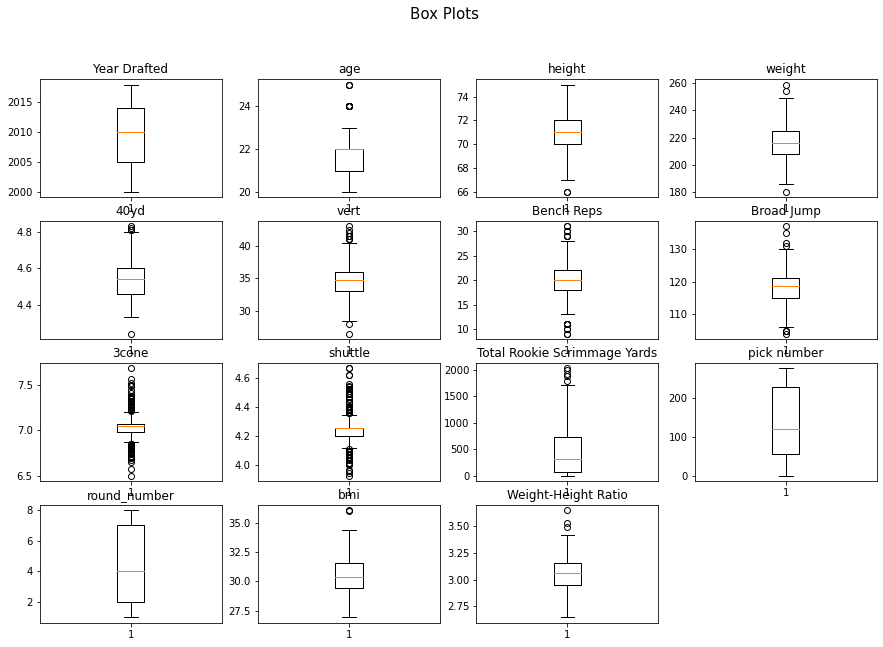

In [22]:
fig = plt.figure(figsize=[15,10])
fig.suptitle("Box Plots", fontsize=15)

ax1 = fig.add_subplot(4,4,1)
ax1.boxplot(train.year_drafted)
ax1.set_title('Year Drafted')

ax1 = fig.add_subplot(4,4,2)
ax1.boxplot(train.age)
ax1.set_title('age')

ax1 = fig.add_subplot(4,4,3)
ax1.boxplot(train.height)
ax1.set_title('height')

ax1 = fig.add_subplot(4,4,4)
ax1.boxplot(train.weight)
ax1.set_title('weight')

ax1 = fig.add_subplot(4,4,5)
ax1.boxplot(train['forty_yd'])
ax1.set_title('40yd')

ax1 = fig.add_subplot(4,4,6)
ax1.boxplot(train.vert)
ax1.set_title('vert')

ax1 = fig.add_subplot(4,4,7)
ax1.boxplot(train.bench_reps)
ax1.set_title('Bench Reps')

ax1 = fig.add_subplot(4,4,8)
ax1.boxplot(train.broad_jump)
ax1.set_title('Broad Jump')

ax1 = fig.add_subplot(4,4,9)
ax1.boxplot(train['three_cone'])
ax1.set_title('3cone')

ax1 = fig.add_subplot(4,4,10)
ax1.boxplot(train.shuttle)
ax1.set_title('shuttle')

ax1 = fig.add_subplot(4,4,11)
ax1.boxplot(train.rookie_scrim_yds)
ax1.set_title('Total Rookie Scrimmage Yards')

ax1 = fig.add_subplot(4,4,12)
ax1.boxplot(train.pick_number)
ax1.set_title('pick number')

ax1 = fig.add_subplot(4,4,13)
ax1.boxplot(train.round_number)
ax1.set_title('round_number')

ax1 = fig.add_subplot(4,4,14)
ax1.boxplot(train.bmi)
ax1.set_title('bmi')

ax1 = fig.add_subplot(4,4,15)
ax1.boxplot(train['weight_height_ratio'])
ax1.set_title('Weight-Height Ratio')


Although there are outliers, they are reasonable outliers that don't need to be removed.

## Correlation Matrix and Heat Map
- use to identify possible multicollinearity
- use to identify possible relationships between features and target
- use to identify target distribution

In [23]:
train.corr()

,year_drafted,age,height,weight,forty_yd,vert,bench_reps,broad_jump,three_cone,shuttle,rookie_scrim_yds,pick_number,round_number,bmi,weight_height_ratio
year_drafted,1.000000,-0.198348,-0.000959,-0.060206,0.061792,-0.035241,-0.123661,0.145354,-0.081483,0.102197,0.043097,0.098988,0.098752,-0.067022,-0.069746
age,-0.198348,1.000000,0.027499,-0.003440,0.135540,-0.029718,0.015548,-0.148287,0.013211,-0.072398,-0.200981,0.286092,0.289996,-0.030342,-0.017449
height,-0.000959,0.027499,1.000000,0.550010,0.001359,0.102210,-0.042295,0.214752,0.064544,0.174990,0.150798,-0.170898,-0.170021,-0.300550,0.171096
weight,-0.060206,-0.003440,0.550010,1.000000,0.216121,0.054864,0.173134,0.060276,0.187670,0.165821,0.140980,-0.124188,-0.125885,0.630394,0.916706
forty_yd,0.061792,0.135540,0.001359,0.216121,1.000000,-0.258045,-0.053375,-0.363281,0.178715,0.151372,-0.272176,0.446715,0.448019,0.246836,0.255121
vert,-0.035241,-0.029718,0.102210,0.054864,-0.258045,1.000000,0.051869,0.594568,-0.162820,-0.256364,0.145528,-0.221042,-0.220498,-0.031822,0.016451
bench_reps,-0.123661,0.015548,-0.042295,0.173134,-0.053375,0.051869,1.000000,0.014559,0.029454,-0.080582,0.023407,-0.074977,-0.087763,0.240636,0.226217
broad_jump,0.145354,-0.148287,0.214752,0.060276,-0.363281,0.594568,0.014559,1.000000,-0.158137,-0.144037,0.248960,-0.377659,-0.379220,-0.130090,-0.030913
three_cone,-0.081483,0.013211,0.064544,0.187670,0.178715,-0.162820,0.029454,-0.158137,1.000000,0.397740,-0.149005,0.202822,0.214163,0.160522,0.193549
shuttle,0.102197,-0.072398,0.174990,0.165821,0.151372,-0.256364,-0.080582,-0.144037,0.397740,1.000000,0.026770,0.060635,0.075493,0.030996,0.114703


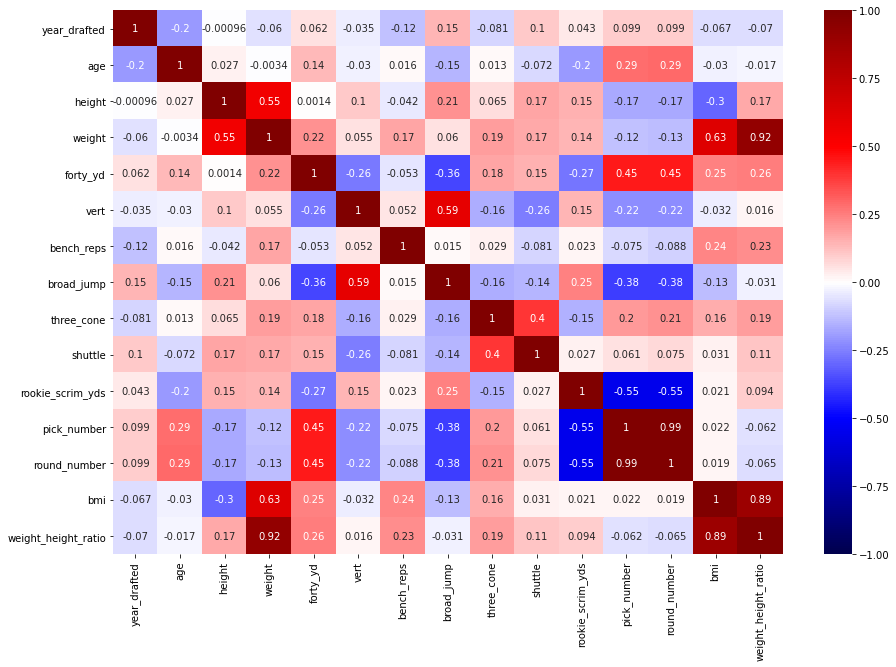

In [24]:
plt.figure(figsize=[15,10])
sns.heatmap(train.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

## Observations:
With relation to target (rookie_scrim_yds):
- Medium correlated (.4-.7): 
    - pick_number (-.55)
    - round_number (-.55)
- low correlation (.1-.4):
    - broad jump (0.25)
    - vert (0.15)
    - 40 yd (-.27)
    - weight (.14)
    - height (.15)
    - age (-.2)
    - 3cone (-.15)
- Minimal correlation (less than 0.1):
    - bench reps (.023)
    - shuttle (0.027)
    - bmi (.021)
    - year drafted (0.043)
    - weight-height_ratio (0.094)

With relation to each other:
- height/weight
    - change to just weight-height ratio and height (drop weight)
    - use just weight-height ratio instead of both this ratio and bmi
- pick_number/round_number
    - just use pick_number, drop round number
- vert/broad jump
    - drop vert (broad jump is more correlated with target than vert is)

In [25]:
# train = train.drop(columns=['vert','weight','bmi','bench_reps'])
train = train.drop(columns=['weight','bmi','round_number'])

<Figure size 1080x720 with 0 Axes>

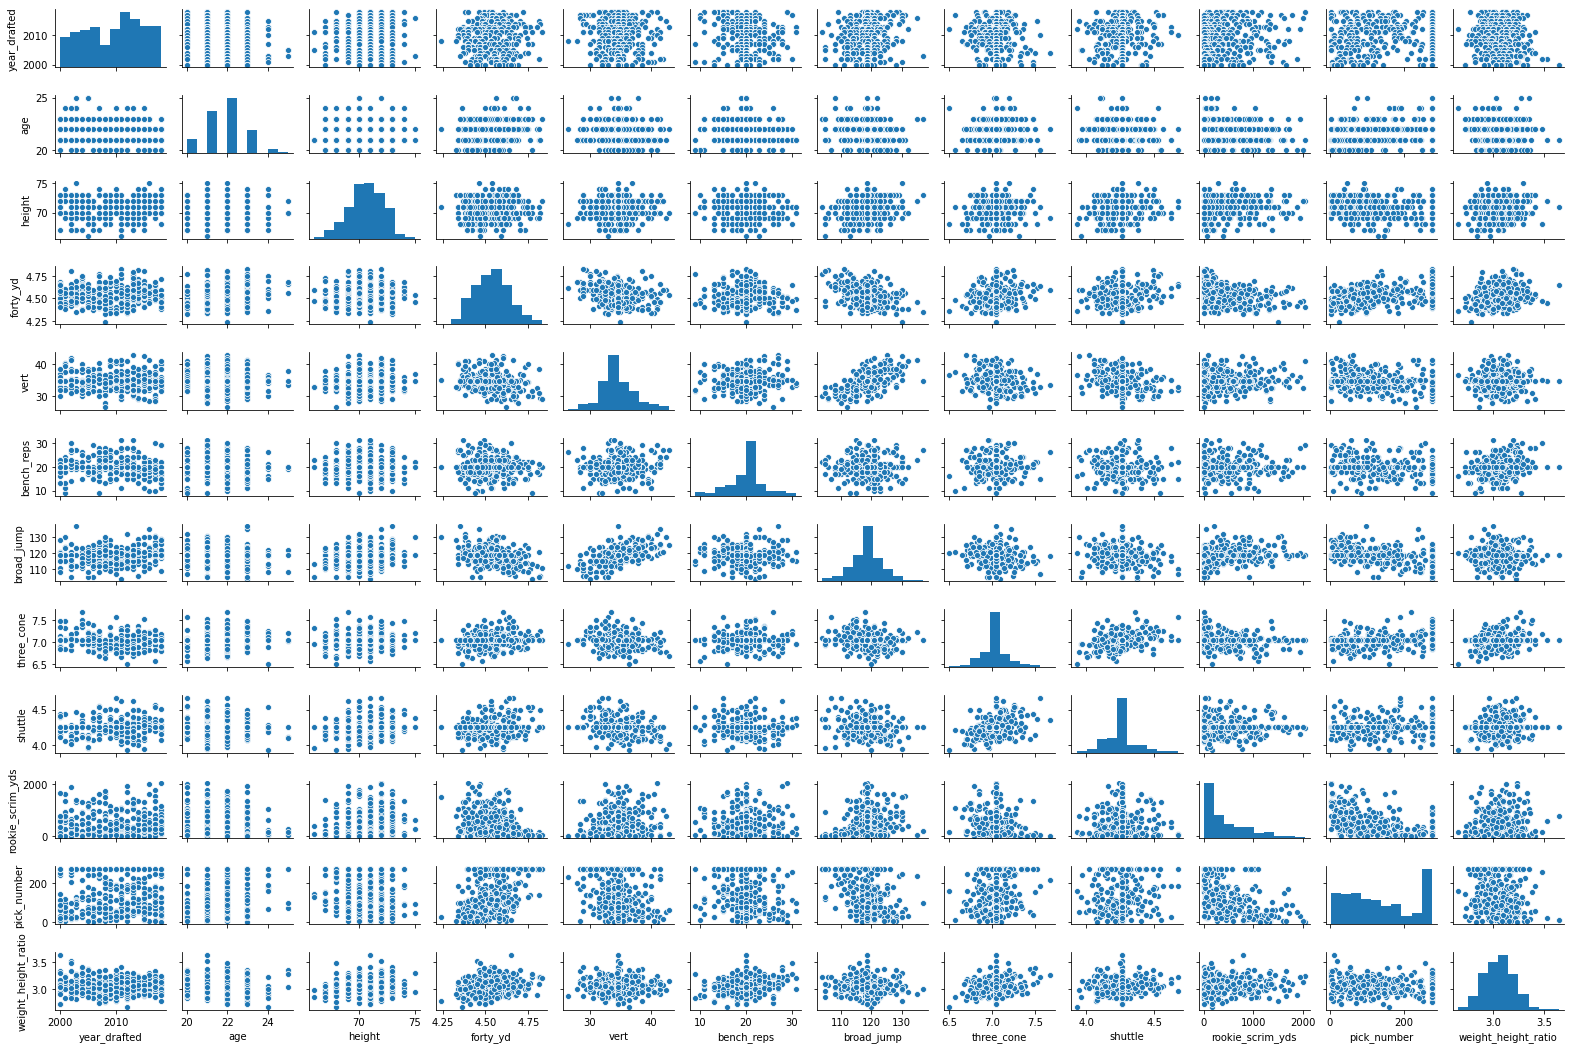

In [26]:
plt.figure(figsize=[15,10])
sns.pairplot(train,height=1.2,aspect=1.5)

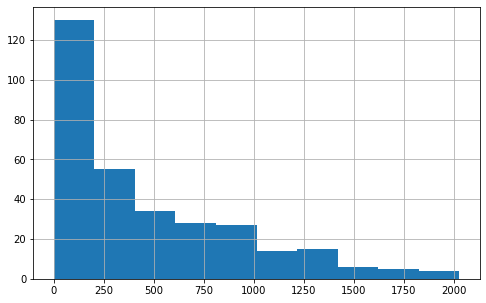

In [27]:
#histogram of target:
fighist = plt.figure(figsize=[8,5])
train['rookie_scrim_yds'].hist()
fighist.savefig('initial_yhist.png');

**rookie_scrim_yds histogram is skewed heavily to right. take log(x) to dampen the lower x values**

## Initial Model (before log transfomation of target, before dropping other columns):

In [28]:
# Create your feature matrix (X) and target vector (y)
# below: 'Y is target, X1, X2, etc. are all the variables you want to use
y, X = patsy.dmatrices('rookie_scrim_yds ~ age + height + forty_yd + broad_jump + vert + bench_reps + three_cone + shuttle + pick_number + weight_height_ratio', data=train, return_type="dataframe")

# Create your model
# notice, its y, THEN x
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       rookie_scrim_yds   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     14.79
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           1.76e-21
Time:                        08:46:00   Log-Likelihood:                -2345.0
No. Observations:                 318   AIC:                             4712.
Df Residuals:                     307   BIC:                             4753.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1058.8799   1920.053      0.551      0.582   -2719.249    4837.008
age                   -20.5996     23.260     -0.886      0.377     -66.369      25.170
height                 10.7978     14.050      0.769      0.443     -16.849      38.445
forty_yd             -279.2225    260.598     -1.071      0.285    -792.008     233.563
broad_jump              2.5211      5.890      0.428      0.669      -9.069      14.111
vert                    1.7394     10.247      0.170      0.865     -18.424      21.903
bench_reps             -3.0333      6.096     -0.498      0.619     -15.028       8.961
three_cone           -268.9753    164.383     -1.636      0.103    -592.435      54.485
shuttle               344.5301    220.355      1.564      0.119     -89.067     778.127
pick_number            -2.4356      0.298     -8.170      0.000      -3.022      -1.849
weight_height_ratio   267.0765    163.078      1.638      0.103     -53.816     587.969
==============================================================================
Omnibus:                       44.916   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.732
Skew:                           0.944   Prob(JB):                     3.94e-14
Kurtosis:                       4.048   Cond. No.                     1.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Initial R2 = 0.325
- Initial Adj. R2 = 0.303
- Lots of high p-values (vert,broad_jump,bench_reps,intercept,age)

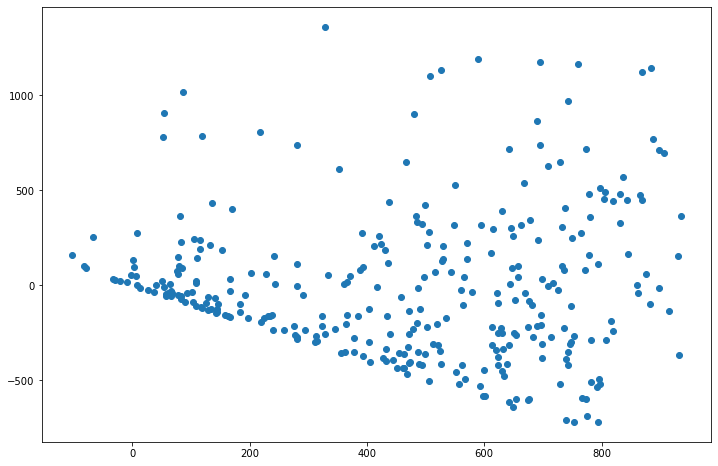

In [29]:
#plot the residual:
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(fit.predict(), fit.resid);

Residual vs. fitted values has a lower bound. To fix this, use a log-linear model (take the logarithm of the target variable before fitting the regression). 

Has lower bound because minimum yards run is 0 (can't go below 0). 

Text(0.5, 1.0, 'Normal Q-Q plot')

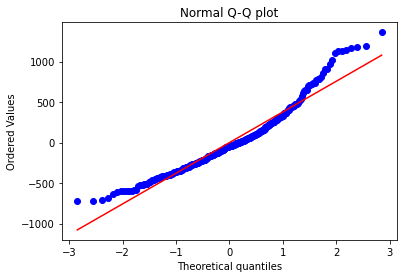

In [30]:
stats.probplot(fit.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

## log-linear model (take the logarithm of the target variable before fitting the regression)

In [36]:
main_df.head()

,year_drafted,name,age,school,height,weight,forty_yd,vert,bench_reps,broad_jump,three_cone,shuttle,rookie_scrim_yds,pick_number,round_number,bmi,weight_height_ratio
Dexter Williams,2019,Dexter Williams,22,Notre Dame,71.0,212,4.57,36.0,17.0,130.0,7.00,4.16,11.0,194,6,29.567671,2.985915
Devin Singletary,2019,Devin Singletary,21,Florida Atlantic,67.0,203,4.66,35.0,15.0,117.0,7.32,4.40,969.0,74,3,31.793943,3.029851
Jordan Scarlett,2019,Jordan Scarlett,23,Florida,71.0,208,4.47,30.0,21.0,116.0,7.37,4.63,9.0,154,5,29.009790,2.929577
Miles Sanders,2019,Miles Sanders,21,Penn State,71.0,211,4.49,36.0,20.0,124.0,6.89,4.19,1327.0,53,2,29.428201,2.971831
Tony Pollard,2019,Tony Pollard,21,Memphis,72.0,210,4.52,35.0,13.0,121.0,7.04,4.26,562.0,128,4,28.480805,2.916667


In [37]:
df_final = main_df.drop(columns=['name','weight','bmi','school','round_number'])
test_df = df_final[df_final['year_drafted']==2019].drop(columns=['year_drafted'])
train_df = df_final[df_final['year_drafted']!=2019].drop(columns=['year_drafted'])
test_df.head()

,age,height,forty_yd,vert,bench_reps,broad_jump,three_cone,shuttle,rookie_scrim_yds,pick_number,weight_height_ratio
Dexter Williams,22,71.0,4.57,36.0,17.0,130.0,7.00,4.16,11.0,194,2.985915
Devin Singletary,21,67.0,4.66,35.0,15.0,117.0,7.32,4.40,969.0,74,3.029851
Jordan Scarlett,23,71.0,4.47,30.0,21.0,116.0,7.37,4.63,9.0,154,2.929577
Miles Sanders,21,71.0,4.49,36.0,20.0,124.0,6.89,4.19,1327.0,53,2.971831
Tony Pollard,21,72.0,4.52,35.0,13.0,121.0,7.04,4.26,562.0,128,2.916667


## Log transformation of y:

In [38]:
#in order to take the log transformation of y, all y values have to be above 0
no_zeros = df_final[df_final['rookie_scrim_yds']>0]
#add a column of all 1's (constant). This will transform the B0 coefficient
no_zeros = sm.add_constant(no_zeros)
#split into test and train:
no_zeros_test = no_zeros[no_zeros['year_drafted']==2019]
no_zeros_train = no_zeros[no_zeros['year_drafted']!=2019]#add a column of all 1's (constant). This will transform the B0 coefficient

In [39]:
y_log_test = np.log(no_zeros_test['rookie_scrim_yds'])
x_log_test = no_zeros_test.drop('rookie_scrim_yds',axis=1)

y_log_train = np.log(no_zeros_train['rookie_scrim_yds'])
x_log_train = no_zeros_train.drop('rookie_scrim_yds',axis=1)

In [40]:
#Initial Log transformed model:
model_log = sm.OLS(y_log_train, x_log_train)

# Fit your model to your training set
fit_log = model_log.fit()

# Print summary statistics of the model's performance
fit_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       rookie_scrim_yds   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     13.56
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           7.45e-21
Time:                        08:46:00   Log-Likelihood:                -477.20
No. Observations:                 299   AIC:                             978.4
Df Residuals:                     287   BIC:                             1023.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -34.5068     29.646     -1.164      0.245     -92.857      23.844
year_drafted            0.0221      0.015      1.525      0.128      -0.006       0.051
age                     0.0248      0.076      0.326      0.745      -0.125       0.174
height                  0.0053      0.045      0.120      0.905      -0.083       0.093
forty_yd               -0.9194      0.847     -1.085      0.279      -2.587       0.748
vert                    0.0131      0.033      0.397      0.692      -0.052       0.078
bench_reps             -0.0222      0.020     -1.132      0.259      -0.061       0.016
broad_jump              0.0152      0.019      0.787      0.432      -0.023       0.053
three_cone             -1.2007      0.534     -2.248      0.025      -2.252      -0.149
shuttle                 0.9769      0.703      1.390      0.166      -0.406       2.360
pick_number            -0.0081      0.001     -8.289      0.000      -0.010      -0.006
weight_height_ratio     0.7576      0.520      1.456      0.146      -0.266       1.782
==============================================================================
Omnibus:                       22.507   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.574
Skew:                          -0.655   Prob(JB):                     2.80e-06
Kurtosis:                       3.580   Cond. No.                     8.50e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

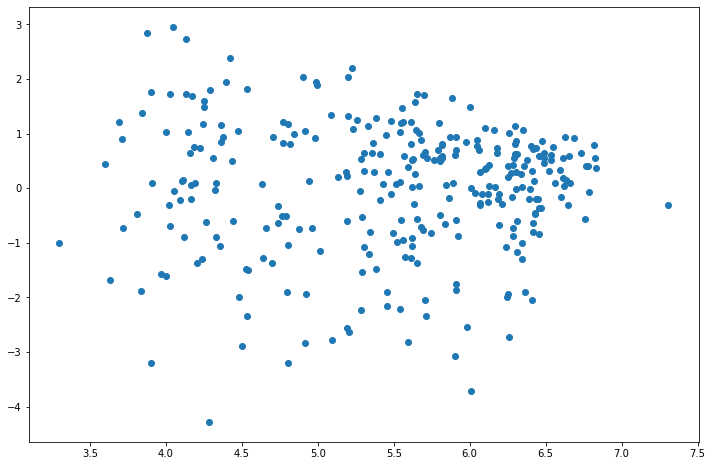

In [41]:
plt.figure(figsize=(12,8))
plt.scatter(fit_log.predict(), fit_log.resid);

The residual plot looks so much better (much more random)!

Text(0.5, 1.0, 'Normal Q-Q plot')

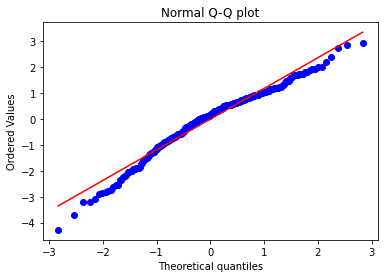

In [42]:
stats.probplot(fit_log.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

The Q-Q plot also looks tremendously better (much more linear)!

<Figure size 1080x720 with 0 Axes>

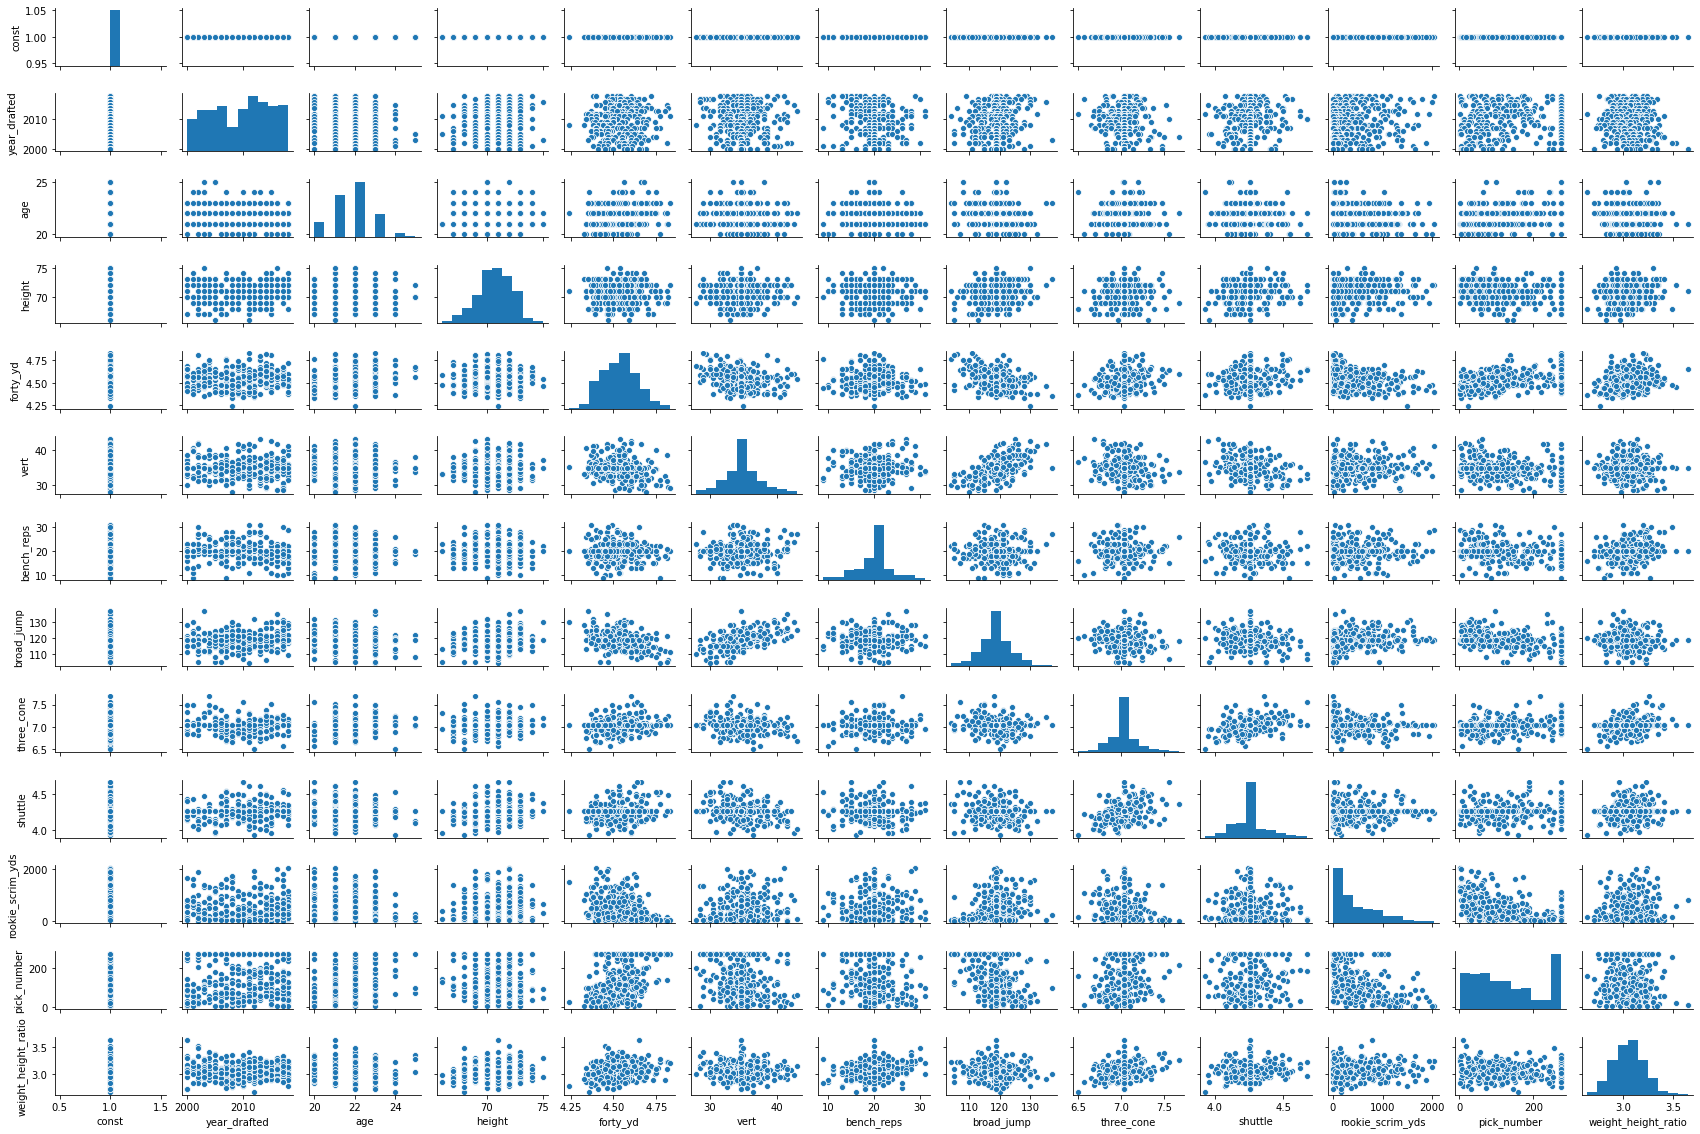

In [43]:
plt.figure(figsize=[15,10])
sns.pairplot(no_zeros_train,height=1.2,aspect=1.5)

Multicollinearity:
- broad_jump and vert (drop vert)

P-values:
- age and height have very high p-values, may want to consider dropping

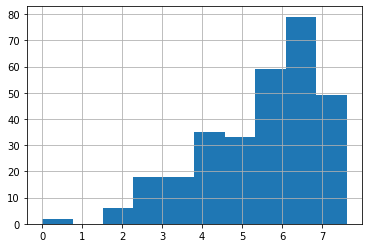

In [44]:
y_log_train.hist()

The target histogram looks more normally distributed (no longer extremely right skewed, but still has a skew - now left skewed).

### Drop vert, age, and height to see if it improves R2:

**Model 2: drop vert only**

In [45]:
log_model2 = no_zeros.drop(columns=['vert'])
#split into test and train:
mod2_test = log_model2[log_model2['year_drafted']==2019]
mod2_train = log_model2[log_model2['year_drafted']!=2019]

In [46]:
y_log2_test = np.log(mod2_test['rookie_scrim_yds'])
x_log2_test = mod2_test.drop('rookie_scrim_yds',axis=1)

y_log2_train = np.log(mod2_train['rookie_scrim_yds'])
x_log2_train = mod2_train.drop('rookie_scrim_yds',axis=1)

In [47]:
#Initial Log transformed model:
model2_log = sm.OLS(y_log2_train, x_log2_train)

# Fit your model to your training set
fit_log2 = model2_log.fit()

# Print summary statistics of the model's performance
fit_log2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       rookie_scrim_yds   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     14.94
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           2.01e-21
Time:                        08:46:44   Log-Likelihood:                -477.28
No. Observations:                 299   AIC:                             976.6
Df Residuals:                     288   BIC:                             1017.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -32.9505     29.342     -1.123      0.262     -90.703      24.802
year_drafted            0.0214      0.014      1.491      0.137      -0.007       0.050
age                     0.0259      0.076      0.341      0.734      -0.123       0.175
height                  0.0055      0.045      0.123      0.902      -0.082       0.093
forty_yd               -0.9266      0.846     -1.096      0.274      -2.591       0.738
bench_reps             -0.0222      0.020     -1.130      0.260      -0.061       0.016
broad_jump              0.0193      0.016      1.184      0.237      -0.013       0.051
three_cone             -1.2098      0.533     -2.270      0.024      -2.259      -0.161
shuttle                 0.9305      0.692      1.345      0.180      -0.431       2.292
pick_number            -0.0081      0.001     -8.292      0.000      -0.010      -0.006
weight_height_ratio     0.7668      0.519      1.478      0.141      -0.255       1.788
==============================================================================
Omnibus:                       22.400   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.399
Skew:                          -0.655   Prob(JB):                     3.05e-06
Kurtosis:                       3.569   Cond. No.                     8.42e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R2 stayed the same. Adj. R2 went up slightly, indicating that model 1 was slightly overfit. Good idea to remove this feature.

**Model 3: drop age only**

In [48]:
log_model3 = no_zeros.drop(columns=['age'])
#split into test and train:
mod3_test = log_model3[log_model3['year_drafted']==2019]
mod3_train = log_model3[log_model3['year_drafted']!=2019]

In [49]:
y_log3_test = np.log(mod3_test['rookie_scrim_yds'])
x_log3_test = mod3_test.drop('rookie_scrim_yds',axis=1)

y_log3_train = np.log(mod3_train['rookie_scrim_yds'])
x_log3_train = mod3_train.drop('rookie_scrim_yds',axis=1)

In [50]:
#Initial Log transformed model:
model3_log = sm.OLS(y_log3_train, x_log3_train)

# Fit your model to your training set
fit_log3 = model3_log.fit()

# Print summary statistics of the model's performance
fit_log3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       rookie_scrim_yds   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     14.95
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           1.96e-21
Time:                        08:46:44   Log-Likelihood:                -477.25
No. Observations:                 299   AIC:                             976.5
Df Residuals:                     288   BIC:                             1017.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -31.8131     28.425     -1.119      0.264     -87.760      24.134
year_drafted            0.0211      0.014      1.492      0.137      -0.007       0.049
height                  0.0068      0.044      0.154      0.878      -0.080       0.094
forty_yd               -0.9187      0.846     -1.086      0.278      -2.583       0.746
vert                    0.0135      0.033      0.410      0.682      -0.051       0.079
bench_reps             -0.0220      0.020     -1.121      0.263      -0.061       0.017
broad_jump              0.0149      0.019      0.772      0.441      -0.023       0.053
three_cone             -1.2051      0.533     -2.260      0.025      -2.255      -0.156
shuttle                 0.9605      0.700      1.372      0.171      -0.417       2.338
pick_number            -0.0080      0.001     -8.563      0.000      -0.010      -0.006
weight_height_ratio     0.7545      0.519      1.453      0.147      -0.268       1.777
==============================================================================
Omnibus:                       22.752   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.920
Skew:                          -0.659   Prob(JB):                     2.35e-06
Kurtosis:                       3.588   Cond. No.                     8.16e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R2 stayed the same. Adj. R2 went up slightly, indicating that model 1 was slightly overfit. Good idea to remove this feature.

**Model 4: Drop height only**

In [51]:
log_model4 = no_zeros.drop(columns=['height'])
#split into test and train:
mod4_test = log_model4[log_model4['year_drafted']==2019]
mod4_train = log_model4[log_model4['year_drafted']!=2019]

In [52]:
y_log4_test = np.log(mod4_test['rookie_scrim_yds'])
x_log4_test = mod4_test.drop('rookie_scrim_yds',axis=1)

y_log4_train = np.log(mod4_train['rookie_scrim_yds'])
x_log4_train = mod4_train.drop('rookie_scrim_yds',axis=1)

In [53]:
#Initial Log transformed model:
model4_log = sm.OLS(y_log4_train, x_log4_train)

# Fit your model to your training set
fit_log4 = model4_log.fit()

# Print summary statistics of the model's performance
fit_log4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       rookie_scrim_yds   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     14.96
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           1.88e-21
Time:                        08:46:44   Log-Likelihood:                -477.20
No. Observations:                 299   AIC:                             976.4
Df Residuals:                     288   BIC:                             1017.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -34.3133     29.551     -1.161      0.247     -92.476      23.850
year_drafted            0.0221      0.014      1.528      0.128      -0.006       0.051
age                     0.0257      0.076      0.340      0.734      -0.123       0.174
forty_yd               -0.9161      0.845     -1.084      0.279      -2.580       0.747
vert                    0.0132      0.033      0.399      0.690      -0.052       0.078
bench_reps             -0.0224      0.020     -1.143      0.254      -0.061       0.016
broad_jump              0.0156      0.019      0.821      0.412      -0.022       0.053
three_cone             -1.1998      0.533     -2.250      0.025      -2.249      -0.150
shuttle                 0.9922      0.690      1.438      0.151      -0.366       2.350
pick_number            -0.0081      0.001     -8.366      0.000      -0.010      -0.006
weight_height_ratio     0.7659      0.515      1.488      0.138      -0.247       1.779
==============================================================================
Omnibus:                       22.219   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.174
Skew:                          -0.651   Prob(JB):                     3.42e-06
Kurtosis:                       3.573   Cond. No.                     8.48e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R2 stayed the same. Adj. R2 went up slightly, indicating that model 1 was slightly overfit. Good idea to remove this feature.

**Model 5: remove all 3 (vert, age, and height)**

In [54]:
log_model5 = no_zeros.drop(columns=['vert','age','height'])
#split into test and train:
mod5_test = log_model5[log_model5['year_drafted']==2019]
mod5_train = log_model5[log_model5['year_drafted']!=2019]

In [55]:
y_log5_test = np.log(mod5_test['rookie_scrim_yds'])
x_log5_test = mod5_test.drop('rookie_scrim_yds',axis=1)

y_log5_train = np.log(mod5_train['rookie_scrim_yds'])
x_log5_train = mod5_train.drop('rookie_scrim_yds',axis=1)

In [56]:
#Initial Log transformed model:
model5_log = sm.OLS(y_log5_train, x_log5_train)

# Fit your model to your training set
fit_log5 = model5_log.fit()

# Print summary statistics of the model's performance
fit_log5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       rookie_scrim_yds   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     18.78
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           1.13e-22
Time:                        08:46:44   Log-Likelihood:                -477.35
No. Observations:                 299   AIC:                             972.7
Df Residuals:                     290   BIC:                             1006.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -29.6900     27.912     -1.064      0.288     -84.625      25.245
year_drafted            0.0203      0.014      1.453      0.147      -0.007       0.048
forty_yd               -0.9217      0.842     -1.094      0.275      -2.580       0.736
bench_reps             -0.0221      0.020     -1.131      0.259      -0.060       0.016
broad_jump              0.0196      0.016      1.234      0.218      -0.012       0.051
three_cone             -1.2139      0.531     -2.286      0.023      -2.259      -0.169
shuttle                 0.9312      0.677      1.376      0.170      -0.401       2.263
pick_number            -0.0080      0.001     -8.623      0.000      -0.010      -0.006
weight_height_ratio     0.7749      0.513      1.512      0.132      -0.234       1.784
==============================================================================
Omnibus:                       22.288   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.247
Skew:                          -0.653   Prob(JB):                     3.29e-06
Kurtosis:                       3.567   Cond. No.                     8.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R2 is 0.001 lower than R2s of just dropping one feature. 

However, Adj. R2 is much higher than any of the previous models, indicating that those models are overfitting. This is the best linear regression model.

Let's perform Lasso and Ridge Regressions (on the original log model) to see which method does best. Then I'll confirm that dropping those features (vert, height, age) is a good idea.

In [57]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(x_log_train, y_log_train, test_size=.25, random_state=3)

In [58]:
lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

# fit(mean and std) on train, (scaler remembers this fit) transform on test. test also needs to be scaled by same scale as training data
X_train_scaled = scaler.fit_transform(X_train1.values)
X_val_scaled = scaler.transform(X_val1.values)
X_test_scaled = scaler.transform(x_log_test.values)

lm_reg = Ridge(alpha=20)
lm_lasso = Lasso(alpha=0.023)

In [59]:
#validate

lm.fit(X_train1, y_train1)
print(f'Linear Regression train R^2: {lm.score(X_train1, y_train1):.3f}')
print(f'Linear Regression val R^2: {lm.score(X_val1, y_val1):.3f}')

lm_reg.fit(X_train_scaled, y_train1)
print(f'Ridge Regression train R^2: {lm_reg.score(X_train_scaled, y_train1):.3f}')
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val1):.3f}')

lm_lasso.fit(X_train_scaled, y_train1)
print(f'Lasso regression train R^2: {lm_lasso.score(X_train_scaled, y_train1):.3f}')
print(f'Lasso regression val R^2: {lm_lasso.score(X_val_scaled, y_val1):.3f}')


Linear Regression train R^2: 0.352
Linear Regression val R^2: 0.267
Ridge Regression train R^2: 0.349
Ridge Regression val R^2: 0.276
Lasso regression train R^2: 0.349
Lasso regression val R^2: 0.275


In [60]:
# linear regression with age, vert, and height dropped:
X_train5, X_val5, y_train5, y_val5 = train_test_split(x_log5_train, y_log5_train, test_size=.25, random_state=3)

In [61]:
lm5 = LinearRegression()

In [62]:
#validate

lm5.fit(X_train5, y_train5)
print(f'Linear Regression train R^2: {lm5.score(X_train5, y_train5):.3f}')
print(f'Linear Regression val R^2: {lm5.score(X_val5, y_val5):.3f}')

Linear Regression train R^2: 0.349
Linear Regression val R^2: 0.279


After experimenting with linear regression, ridge regression, and lasso regression, (and different alpha parameters for Ridge and Lasso), linear regression (with age, vert, and height features removed) proved to be the best choice, as this resulted in the highest average R2 values between the train and the validation.

In [63]:
#coefficients for this model (log(target), dropped vert, height, and age):
list(zip(X_train5.columns,lm5.coef_))

[('const', 0.0),
 ('year_drafted', 0.014958290758760644),
 ('forty_yd', -0.7028976940283518),
 ('bench_reps', -0.024684937555486217),
 ('broad_jump', 0.017176795631067627),
 ('three_cone', -1.6132033774036718),
 ('shuttle', 1.2404085466818324),
 ('pick_number', -0.008147930150503893),
 ('weight_height_ratio', 0.8466506561215071)]

## Cross Validation for Final Model:

In [64]:
Xlog5, ylog5 = np.array(X_train5), np.array(y_train5)

In [65]:
kf = KFold(n_splits=5, shuffle=True, random_state = 44) #split into 5 different groups.
cv_lm_r2s = [] #collect the validation results for both models
# cv_lm_r2s will keep r2 values for all 5 splits
# cv_lm_reg_r2s keeps r2 values for all 5 splits with regularization model

for train_ind, val_ind in kf.split(Xlog5,ylog5):
    
    X_train, y_train = Xlog5[train_ind], ylog5[train_ind]
    X_val, y_val = Xlog5[val_ind], ylog5[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))

print('Simple regression scores: ', cv_lm_r2s)

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')


Simple regression scores:  [0.17478871880520896, 0.23305650669367528, 0.10705004878401059, 0.3590887170440472, 0.3347869330973776]
Simple mean cv r^2: 0.242 +- 0.095


### Predicting the target values for my test group (from final model):

In [66]:
test_set_pred5 = lm5.predict(x_log5_test)

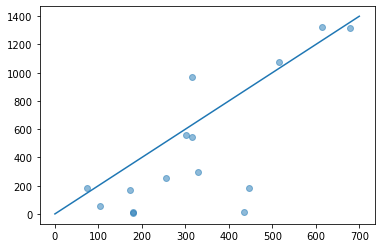

In [67]:
plt.scatter(np.exp(test_set_pred5),np.exp(y_log5_test), alpha=0.5)
plt.plot(np.linspace(0,700,1000), np.linspace(0,1400,1000))

Plot is somewhat linear with most points landing pretty close to the line and only a few points straying far from the line.

In [68]:
y_log5_test

Dexter Williams       2.397895
Devin Singletary      6.876265
Jordan Scarlett       2.197225
Miles Sanders         7.190676
Tony Pollard          6.331502
Qadree Ollison        4.043051
David Montgomery      6.979145
Alexander Mattison    6.298949
Josh Jacobs           7.182352
Travis Homer          5.135798
Justice Hill          5.686975
Darrell Henderson     5.214936
Damien Harris         2.484907
Myles Gaskin          5.214936
Ryquell Armstead      5.529429
Name: rookie_scrim_yds, dtype: float64

In [69]:
test_set_pred5

array([5.1907497 , 5.74998284, 5.18614992, 6.42146405, 5.70868972,
       4.64910492, 6.24583159, 5.75397301, 6.51950194, 5.14873781,
       5.79778216, 6.10054936, 6.07667943, 4.29620776, 5.54121853])

To get the r2 score, you have to take the exponential of both the predicted and the actual targets (since the target was log-transformed):

In [70]:
exp_y_log = np.exp(y_log5_test)
exp_pred = np.exp(test_set_pred5)

r2_score(exp_y_log,exp_pred)

0.3478132058186155

This R2 is somewhat decent (better than I expected). I think the R2 could have been improved if I split up my samples more evenly (ie. had more samples in my test group instead of just the 15 players from the 2019 draft). I also probably overfit my model which is why my model's train R2 was higher than my test R2. Overall, I think the whole process could have been more accurate if I had a larger sample size, and especially a larger test size. 

In [71]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(exp_y_log,exp_pred)

284.92016328493094

On average, my model is off by about 285 yards, which considering some NFL players far underperform and far overperform their projected yards in real life, an error of 285 is not all that much. Phillip Lindsay, for example, was projected to have 0 yards his rookie year, but he actually ran 1278 yards. My model predicted he would run 209 yards which is much closer to his actual yards run than (probably) many other projections.